In [1]:
import pandas as pd
import numpy as np
import os
import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

## Importing CSV file of preprocessed audio file

In [2]:
df = pd.read_csv('balanced-all.csv')
df.head()

,filename,gender
0,data/cv-other-train/sample-069205.npy,female
1,data/cv-valid-train/sample-063134.npy,female
2,data/cv-other-train/sample-080873.npy,female
3,data/cv-other-train/sample-105595.npy,female
4,data/cv-valid-train/sample-144613.npy,female


## Number of Samples of each label

In [3]:
# Total samples 
n_samples = len(df)
print("Total_samples:",n_samples)
# Samples of male audio
n_male = len(df[df['gender']=='male'])
print("Total male samples:",n_male)
# Samples of Female audio
n_female = len(df[df['gender']=='female'])
print("Total female samples:",n_female)

Total_samples: 66938
Total male samples: 33469
Total female samples: 33469


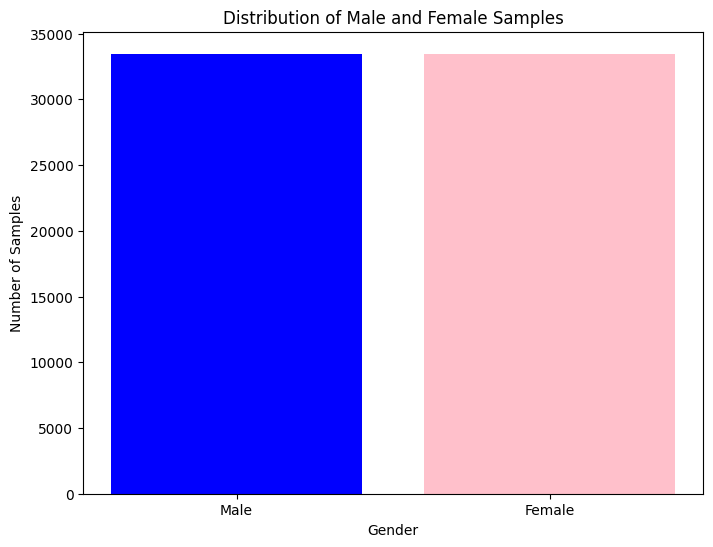

In [4]:
import matplotlib.pyplot as plt
# Plotting the graph
labels = ['Male', 'Female']
sizes = [n_male, n_female]
colors = ['blue', 'pink']  # You can customize colors as needed

plt.figure(figsize=(8, 6))
plt.bar(labels, sizes, color=colors)
plt.title('Distribution of Male and Female Samples')
plt.xlabel('Gender')
plt.ylabel('Number of Samples')
plt.show()

## Loading the Dataset and extracting the features

In [5]:
label2int = {
    "male": 1,
    "female": 0
}

def load_data(vector_length=128):
    """A function to load gender recognition dataset from `data` folder
    After the second run, this will load from results/features.npy and results/labels.npy files
    as it is much faster!"""
    # make sure results folder exists
    if not os.path.isdir("results"):
        os.mkdir("results")
    # if features & labels already loaded individually and bundled, load them from there instead
    if os.path.isfile("results/features.npy") and os.path.isfile("results/labels.npy"):
        X = np.load("results/features.npy")
        y = np.load("results/labels.npy")
        return X, y
    # read dataframe
    df = pd.read_csv("balanced-all.csv")
    # get total samples
    n_samples = len(df)
   
    # initialize an empty array for all audio features
    X = np.zeros((n_samples, vector_length))
    # initialize an empty array for all audio labels (1 for male and 0 for female)
    y = np.zeros((n_samples, 1))
    for i, (filename, gender) in tqdm.tqdm(enumerate(zip(df['filename'], df['gender'])), "Loading data", total=n_samples):
        features = np.load(filename)
        X[i] = features
        y[i] = label2int[gender]
    # save the audio features and labels into files
    # so we won't load each one of them next run
    np.save("results/features", X)
    np.save("results/labels", y)
    return X, y

In [6]:
X, y = load_data()

## Splitting of Dataset for training and testing

In [7]:
# Splitting of data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=7)
X_train,X_valid, y_train,y_valid = train_test_split(X_train,y_train, test_size=0.1,random_state=7)

## Creating the model

In [8]:
#Building of model
def create_model(vector_length = 128):
    model =Sequential()
    model.add(Dense(32, input_shape =(vector_length,)))
    model.add(Dropout(0.3))
    model.add(Dense(64,activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(128,activation = "relu"))
    model.add(Dropout(0.3))
    model.add(Dense(1,activation = "sigmoid"))
    model.compile(loss="binary_crossentropy", metrics=["accuracy"], optimizer="adam")
    model.summary()
    return model

In [9]:
model = create_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                4128      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               1

In [10]:
# use tensorboard to view metrics
tensorboard = TensorBoard(log_dir="logs")

In [11]:
early_stopping = EarlyStopping(mode="min", patience=5, restore_best_weights=True)
batch_size = 8
epochs = 100
# train the model using the training set and validating using validation set
History = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid),
          callbacks=[tensorboard, early_stopping])

Epoch 1/100
6778/6778 [==============================] - 27s 4ms/step - loss: 0.5184 - accuracy: 0.7877 - val_loss: 0.3688 - val_accuracy: 0.8551
Epoch 2/100
6778/6778 [==============================] - 32s 5ms/step - loss: 0.4069 - accuracy: 0.8437 - val_loss: 0.3445 - val_accuracy: 0.8649
Epoch 3/100
6778/6778 [==============================] - 26s 4ms/step - loss: 0.3875 - accuracy: 0.8532 - val_loss: 0.3319 - val_accuracy: 0.8617
Epoch 4/100
6778/6778 [==============================] - 28s 4ms/step - loss: 0.3757 - accuracy: 0.8601 - val_loss: 0.3354 - val_accuracy: 0.8737
Epoch 5/100
6778/6778 [==============================] - 27s 4ms/step - loss: 0.3648 - accuracy: 0.8612 - val_loss: 0.3074 - val_accuracy: 0.8810
Epoch 6/100
6778/6778 [==============================] - 27s 4ms/step - loss: 0.3651 - accuracy: 0.8621 - val_loss: 0.3031 - val_accuracy: 0.8841
Epoch 7/100
6778/6778 [==============================] - 24s 4ms/step - loss: 0.3576 - accuracy: 0.8670 - val_loss: 0.3059 -

## Evaluating the model

In [12]:
print(f"Evaluating the model using {len(X_test)} samples...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy*100:.2f}%")

Evaluating the model using 6694 samples...
Loss: 0.2829
Accuracy: 89.35%


In [13]:
pred = model.predict(X_test)

210/210 [==============================] - 0s 2ms/step


## Plotting the required graph

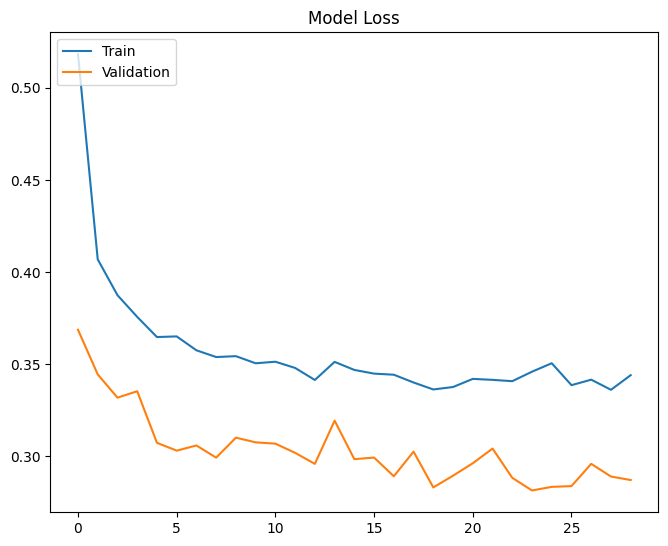

In [14]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.xlabel=('Epoch')
plt.ylabel=('Loss')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

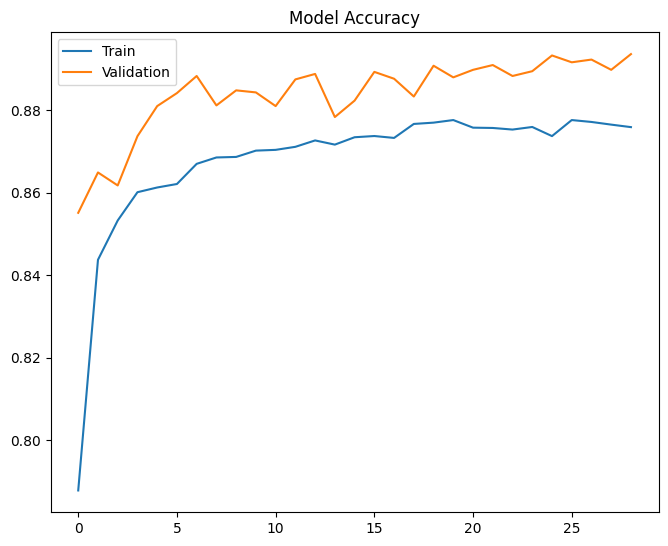

In [15]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel=('Epoch')
plt.ylabel=('Accuracy')
plt.legend(['Train','Validation'],loc='upper left')
plt.subplots_adjust(top=1.0,bottom=0.0,right=0.95,left=0,hspace=0.25,wspace=0.35)

## Saving the model

In [16]:
model.save("results/model.h5")

C:\Users\Maitri Savla\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Extracting all important feature of Audio file

In [40]:
import librosa
import numpy as np

def extract_feature(file_name, **kwargs):
    """
    Extract feature from audio file `file_name`
        Features supported:
            - MFCC (mfcc)
            - Chroma (chroma)
            - MEL Spectrogram Frequency (mel)
            - Contrast (contrast)
            - Tonnetz (tonnetz)
        e.g:
        `features = extract_feature(path, mel=True, mfcc=True)`
    """
    mfcc = kwargs.get("mfcc")
    chroma = kwargs.get("chroma")
    mel = kwargs.get("mel")
    contrast = kwargs.get("contrast")
    tonnetz = kwargs.get("tonnetz")
    X, sample_rate = librosa.core.load(file_name)
    if chroma or contrast:
        stft = np.abs(librosa.stft(X))
    result = np.array([])
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        result = np.hstack((result, mfccs))
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, chroma))
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)
        result = np.hstack((result, mel))
    if contrast:
        contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
        result = np.hstack((result, contrast))
    if tonnetz:
        tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
        result = np.hstack((result, tonnetz))
    return result

In [41]:
# The above function is responsible for loading the audio file and extracting features from it.
# we will use argparse module to parse an audio file path from cmd and make inference on it.

import argparse

parser = argparse.ArgumentParser(description="""Gender recognition script, this will load the model you trained, 
                                    and perform inference on a sample you provide (either using your voice or a file)""")
parser.add_argument("-f", "--file", help="The path to the file, preferred to be in WAV format")
args = parser.parse_args()
file = args.file
# construct the model
model = create_model()
# load the saved/trained weights
model.load_weights("results/model.h5")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32)                4128      
                                                                 
 dropout_24 (Dropout)        (None, 32)                0         
                                                                 
 dense_31 (Dense)            (None, 64)                2112      
                                                                 
 dropout_25 (Dropout)        (None, 64)                0         
                                                                 
 dense_32 (Dense)            (None, 128)               8320      
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                                 
 dense_33 (Dense)            (None, 128)              

## Testing some audio file

In [44]:
file = "12.wav"

In [45]:
# extract features and reshape it
features = extract_feature(file, mel=True).reshape(1, -1)

In [46]:
male_prob = model.predict(features)[0][0]
female_prob = 1 - male_prob
gender = "male" if male_prob > female_prob else "female"

1/1 [==============================] - 0s 118ms/step


In [47]:
print("Result:", gender)
print(f"Probabilities::: Male: {male_prob*100:.2f}%    Female: {female_prob*100:.2f}%")

Result: female
Probabilities::: Male: 2.34%    Female: 97.66%


In [48]:
file2 = "test.wav"


In [49]:
features1 = extract_feature(file2, mel=True).reshape(1, -1)

In [50]:
male_prob = model.predict(features1)[0][0]
female_prob = 1 - male_prob
gender = "male" if male_prob > female_prob else "female"

1/1 [==============================] - 0s 38ms/step


In [51]:
print("Result:", gender)
print(f"Probabilities::: Male: {male_prob*100:.2f}%    Female: {female_prob*100:.2f}%")

Result: female
Probabilities::: Male: 2.34%    Female: 97.66%


## Creating report and finding confusion metrics

In [52]:
from sklearn.metrics import confusion_matrix

In [53]:
i=0
Pred_l=[]
while(i<len(pred)):
    Pred_l.append(int(np.round(pred[i])))
    i=i+1

In [54]:
print(len(y_test))
print(len(pred))
print(len(Pred_l))
print(Pred_l)

6694
6694
6694
[1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 

In [55]:
results=confusion_matrix(y_test,Pred_l)

<Axes: >

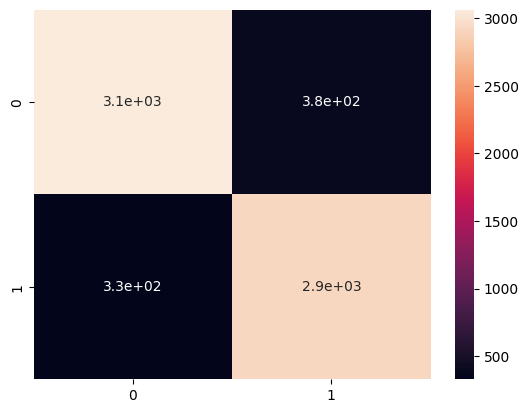

In [56]:
import seaborn as sns
sns.heatmap(results,annot=True)

In [58]:
from sklearn.metrics import classification_report
report=classification_report(y_test,Pred_l)

In [59]:
print(report)

              precision    recall  f1-score   support

         0.0       0.90      0.89      0.90      3450
         1.0       0.88      0.90      0.89      3244

    accuracy                           0.89      6694
   macro avg       0.89      0.89      0.89      6694
weighted avg       0.89      0.89      0.89      6694

